In [ ]:
import sys
!{sys.executable} -m pip install beautifulsoup4 lxml html5lib

In [ ]:
import csv
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import time

headers = {
    'accept': '*/*',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'referer': 'https://www.google.com',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36 Edg/85.0.564.44'
}

def get_article(card):
    """Extract article information from the raw html"""
    raw_link = card.get('href')
    response = requests.get(raw_link, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    article_body = soup.find('div', 'article_body')
    if article_body:
        article_body = soup.find('div', 'article_body').text.replace('\n', ' ').strip()
        return [article_body]

def get_the_news(url):
    """Run the main program"""
    driver = webdriver.Chrome('./chromedriver') 
    driver.get(url) 
    time.sleep(5) 
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    cards = soup.find_all('a', 'newsFeed_item_link')
    # extract articles from page
    articles = []
    for card in cards[:50]:
        article = get_article(card)
        articles.append(article)
        with open('news.csv', 'a', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerows(articles)
        articles = []  
     

# run the main program
get_the_news('https://news.yahoo.co.jp/categories/business')
get_the_news('https://news.yahoo.co.jp/categories/sports')
get_the_news('https://news.yahoo.co.jp/categories/it')
get_the_news('https://news.yahoo.co.jp/categories/science')


In [86]:
import jieba

with open('news.csv') as f:
    japanese_text = f.read()
    japanese_text = japanese_text.split()
print(len(japanese_text))
texts = []
for sentence in japanese_text:
    texts.append(jieba.cut(sentence))
texts = [[word for word in text if len(word)>1] for text in texts]
with open('thesaurus.txt', 'w') as filehandle:
    for listitem in texts:
        filehandle.write("\n".join(map(lambda x: str(x), listitem)))

2355


In [87]:
def is_number(n):
    is_number = True
    try:
        #      v type-casting the number here as `complex`, instead of `float`
        num = complex(n)
        is_number = num == num
    except ValueError:
        is_number = False
    return is_number

def is_english(s):
  return s.isascii()

with open('thesaurus.txt', 'r') as f:
    words = [line.rstrip('\n') for line in f]

print(len(words))

import re
words = [re.sub("[a-zA-Z0-9…！？「」。，、：“”《》；— —（）\s+ ]", '', _) for _ in words]

for w in words:
    if is_number(w) or is_english(w):
        words.remove(w)
print(len(words))

10524
9174


In [88]:
from collections import Counter

def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

# words = preprocess(text)
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 9174
Unique words: 3407


In [89]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[1289, 152, 111, 1291, 12, 12, 1296, 795, 271, 1297, 1302, 1303, 424, 1308, 183, 1309, 223, 111, 1314, 1316, 426, 1323, 426, 426, 114, 326, 426, 273, 1333, 98]


In [90]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [91]:
# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [0, 1, 2, 3, 4, 6, 7, 8, 9]


In [92]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    n_batches = len(words)//batch_size
    # only full batches
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [93]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 2]


In [94]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [95]:
import torch
from torch import nn
import torch.optim as optim

In [96]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

In [97]:
# check if GPU is available
CUDA_LAUNCH_BLOCKING=1.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 50
steps = 0
epochs = 100

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

企業 | 選手写真, 人工, 会員数, 提供展示会, 電池
導入 | 探訪午前, 乱流名古屋, 建国構成, 前日桑原, 中核
細菌 | 今日, 回路百貨店, 失点伊達, 注目, 年時
環境 | 完結, 出身, 八木, 四足歩, 翔平
向上 | 格段, 記念, 情報, 監督, 玄介--
大谷 | 緯度, 立浪, 断念, 一時, 精神
映像 | 失敗完璧失敗失敗, 函館, 高島, 客室, 地点
日本 | 部昇格, 植物性麻婆, 磁場, 当時, 精度
彩子 | 小径, 工学, 投球, 異常反, 段階
松森彩夏 | 演出秘密, 自身, 視野, 退役, 期間
強豪 | 資金引, 葛尾村, 序列, 承知日本, 出典
外野 | 特別, 何台販社, 根尾, 足置, 調子
断裂 | 今春, 予想外, 門家, 球場, 解決策
声援 | 主義, 中央区, 現場, 刑事, 繁盛
世紀 | 雇用, 平和, 緩急, 状態下記, 知名度
旭川 | 限定, 非金融, 藤大輝, 上市, 整備東京国際
...
成績 | 未来社会, 頑固, 年間, 柔軟性, 新規
米国 | 負担, 業績, 業界, 申請, 以上冒頭
大谷 | 緯度, 立浪, 断念, 一時, 精神
選手 | 身体, 大迫, 停止, 資本, 生活
今回 | 形体手回, 少量, 需要一般, 自動, 前日
乱流 | 全米, 役所, 工場, 駐車場, 採用
地区 | 照群, 大谷日本, 空振, 加算現金, 夏休
. | 支給, 信時, 母校, 洋画見放題, 来季
浦河 | 食糧, 映画化群青, 身近, 高層, 員会
黄金 | 素敵玉西武, 貢献帽子, 質再, 新春, 正式
断裂 | 今春, 予想外, 門家, 球場, 解決策
選考 | 離席, 切符, 初回, 将来, 岸田
指名 | 想定, 育成, 取締役, 離籍, 研究最新
大乱 | 本承認, 形成, 外野手, 維持月額, 年目
修正 | 概要, 登場, 勤務, 高飛, 印象
大活躍 | 共有, 遜色, 割合, 共生, 序列
...
地域 | 旅費手, 改善先行, 神出鬼没, 堅持, 編集
移行 | 展開場面, 工学, 一例, 市場動, 若者
細菌 | 今日, 回路百貨店, 注目, 失点伊達, 年時
使用 | 出場今宮, 節電要, 場面前週, 化捉, 想定代表
. | 支給, 信時, 母校, 洋画

In [98]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [99]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()
torch.save(model.state_dict(), 'model.pt')

In [100]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
embed.weight 	 torch.Size([3407, 300])
output.weight 	 torch.Size([3407, 300])
output.bias 	 torch.Size([3407])


In [101]:
model =SkipGram(len(vocab_to_int), embedding_dim).to(device)
model.load_state_dict(torch.load('model.pt'))
embeddings = model.embed.weight.to('cpu').data.numpy()

In [102]:
viz_words = 500
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

/home/julkarnine/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/julkarnine/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


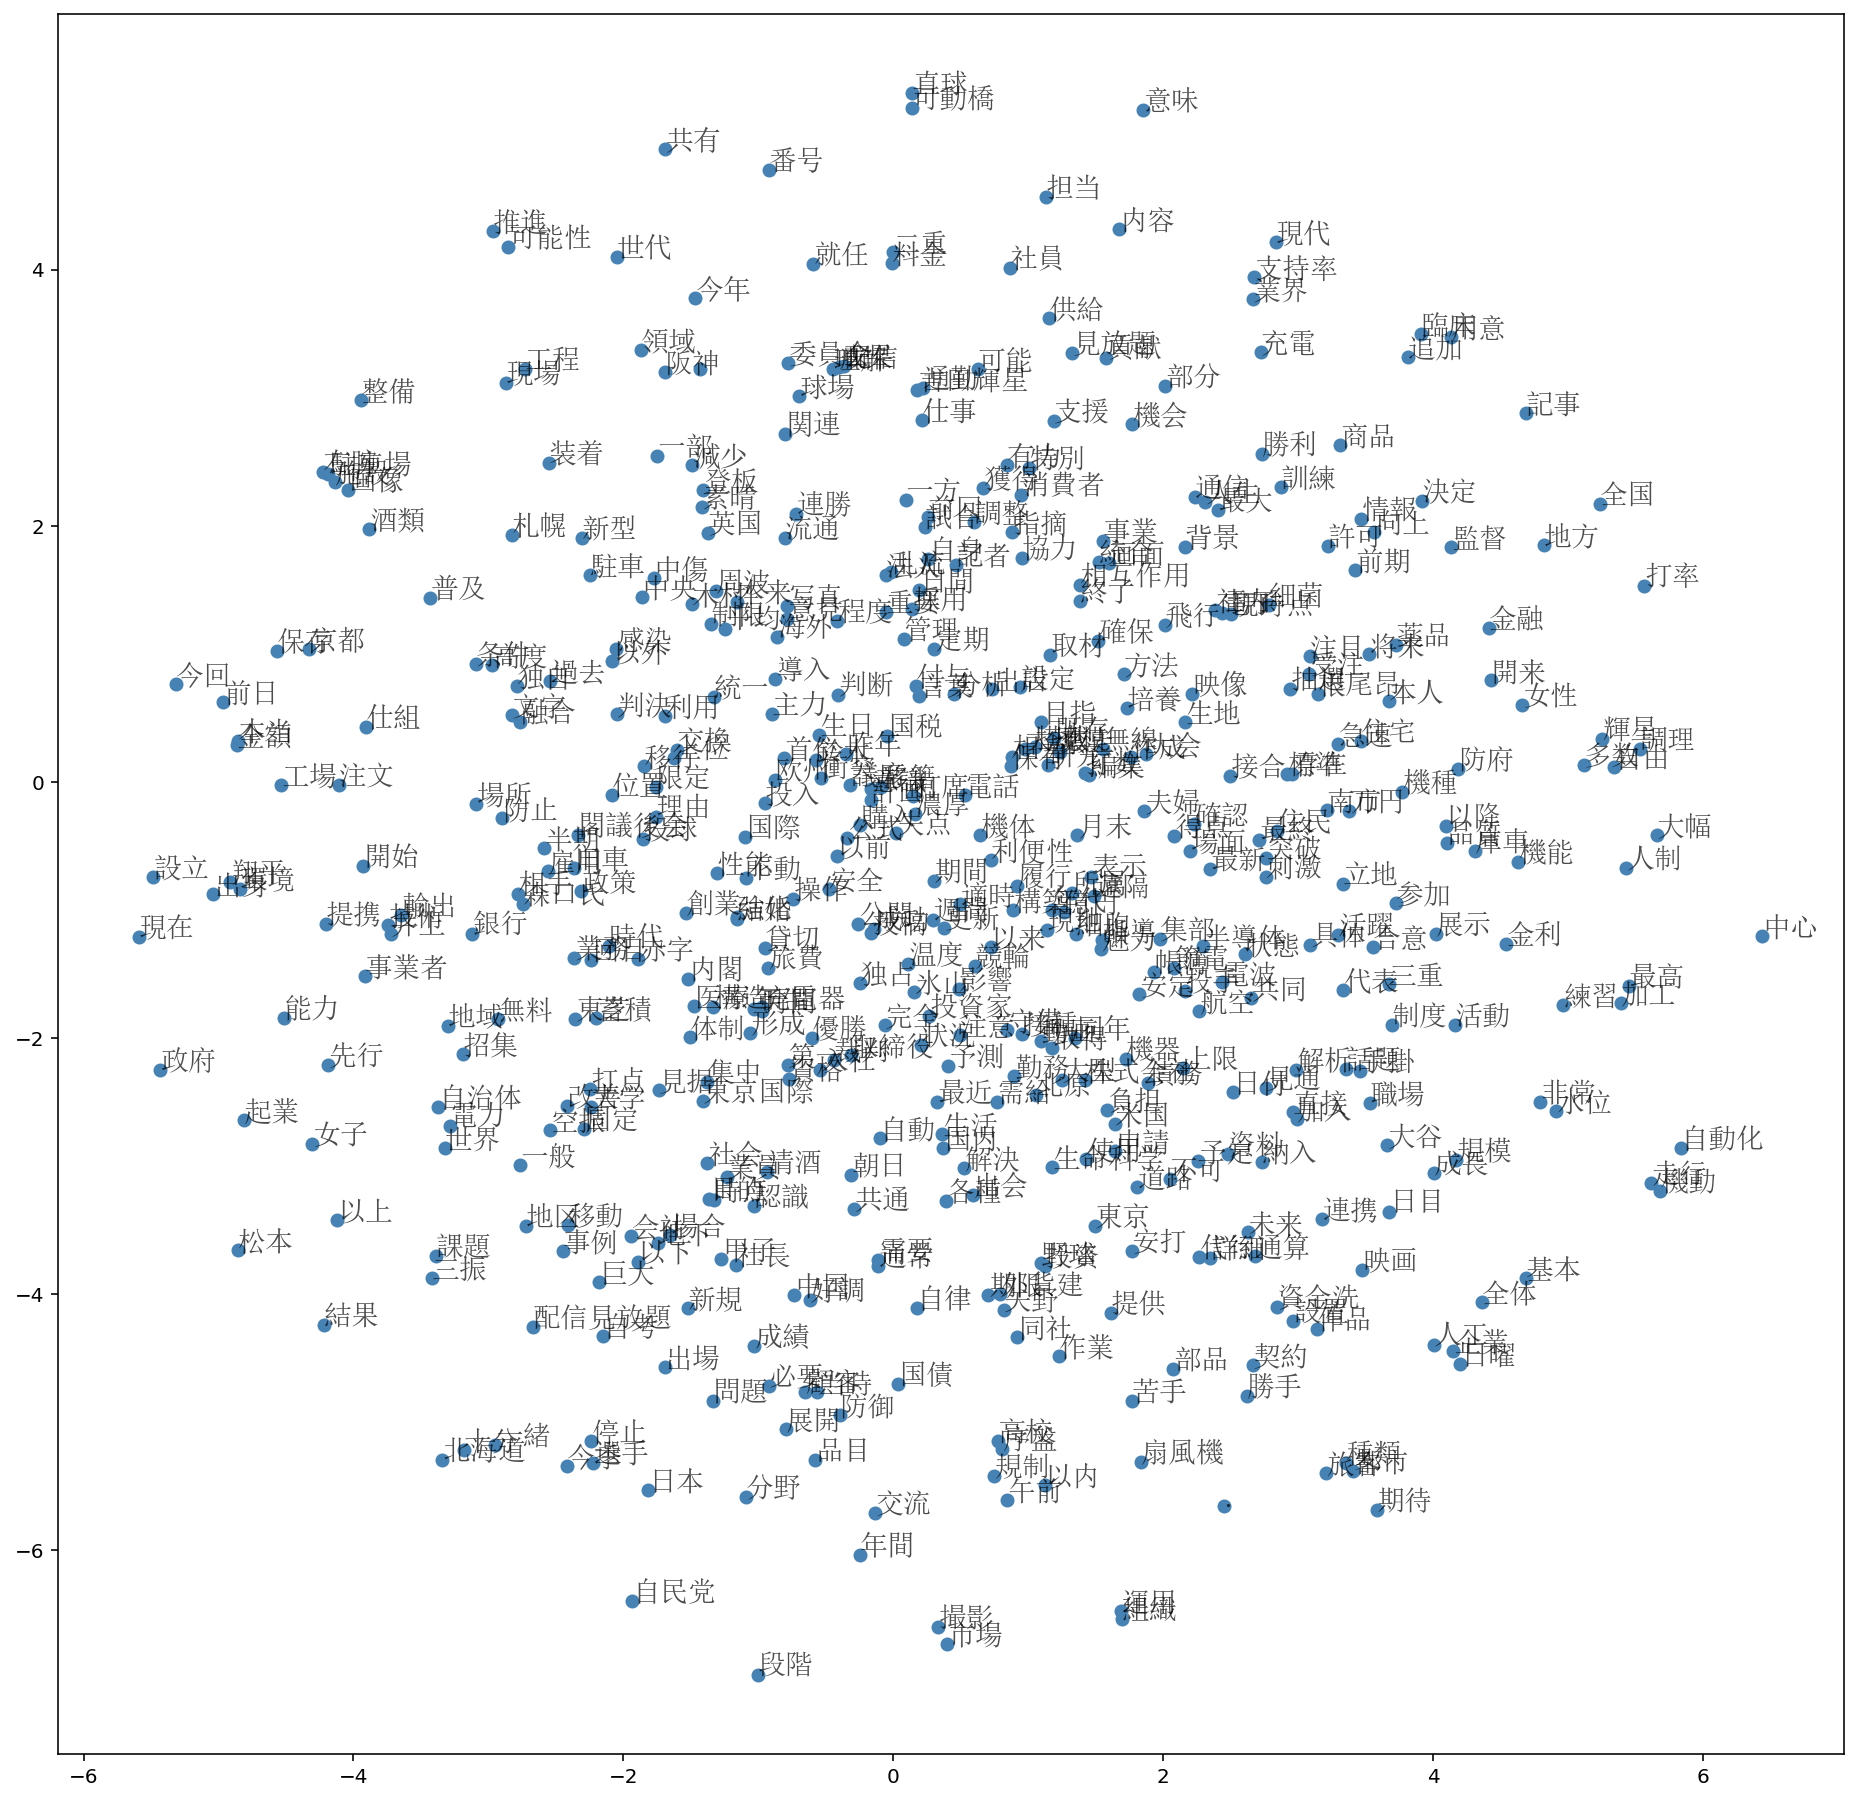

In [103]:
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname=r'simsun.ttc', size=14)

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7 , fontproperties=fp)
    

In [104]:
valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
_, closest_idxs = valid_similarities.topk(6) # topk highest similarities

valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
for ii, valid_idx in enumerate(valid_examples):
    closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
    print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))


札幌 | 松岡大起, 参加写真, 西勇輝, 開示, 中国
作業 | 集部一投手, 前週, 防御, 本部連邦, 出現
東京 | 前田健, 成田, 外角, 江東区, 敢行
環境 | 完結, 出身, 翔平, 八木, 四足歩
三振 | 稼業, 設定設定, 予想外, 事例, 任意優秀
地区 | 照群, 大谷日本, 空振, 加算現金, 夏休
充電 | 有機, 著名, 研究科, 諸国, 活躍一方
追加 | 可能性新型年前, 自動車, 用意, 商品募期間, 俊足打席
仕切 | 垂直, 死球, 承知, 画像通国, 王子
園出場 | 探窟, 話題富岳, 東京鈴木俊一, 離籍, 加担
一体 | 優菜, 封印, 援隊杯争, 精確, 決意問題
連盟 | 通知, 財務相, 負担, 進展企業, 画像展開
外角 | 東京, 辻村氏木村, 集部資金難, 大坂, 達成
心理 | 再開, 交通, 決算動, 前週, 必要時間
東京東京五輪 | 理由, 神奈川, 上院, 見出甲子, 中心
右越 | 大臣節電, 司会者, 苦手, 機会, 青森
